In [1]:
!nvidia-smi

Fri Jun 26 17:54:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install Detectron2 dependencies: https://detectron2.readthedocs.io/tutorials/install.html (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# !pip install awscli # you'll need this if you want to download images from Open Images (we'll see this later)

# Make sure we can import PyTorch (what Detectron2 is built with)
import torch, torchvision
torch.__version__
!gcc --version

# opencv is pre-installed on colab
# !pip install opencv-contrib-python==4.1.2.30

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 72.5MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 276kB 11.1MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=c5acb716787397db85e832ba76d2775e6d629b35f116d26f9e76b02d08dea90a
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-

In [3]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 5.9MB 604kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200623-cp36-none-any.whl size=41183 sha256=4b894393d3ebf9af1ab8bdaff413ac9adc6af0ee0741ff0133115fa3d4901228
  Stored in directory: /root/.cache/pip/wheels/31/b5/a9/df0fd43b263cc96c1d5076ade63fdcdd30fab8699e3366a60c
Successfully built fvcore


**Note:** After running the above two cells, you may need to restart your runtime (Runtime -> Restart runtime). After doing so, you can run the cells below as normal.

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() # this logs Detectron2 information such as what the model is doing when it's training

# import some common libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo # a series of pre-trained Detectron2 models: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
from detectron2.engine import DefaultPredictor # a default predictor class to make predictions on an image using a trained model
from detectron2.config import get_cfg # a config of "cfg" in Detectron2 is a series of instructions for building a model
from detectron2.utils.visualizer import Visualizer # a class to help visualize Detectron2 predictions on an image
from detectron2.data import MetadataCatalog # stores information about the model such as what the training/test data is, what the class names are

# Format the data (images) & label files to be compatiable with Detectron2

In [5]:
# Target classes with spaces removed
target_classes = ['door','stairs','irongate','build_parking']

In [6]:
# # Upload data for fire hydrant as /content/data/sfsu_firehydrant_2_no_segmentation.zip
# !mkdir data
# !mv sfsu_firehydrant_2_no_segmentation.zip data/

In [7]:
# # Unpack data
# # !cd data/
# !unzip ./data/sfsu_firehydrant_2_no_segmentation.zip

In [8]:
# !unzip ./data/sfsu_firehydrant_2_no_segmentation.zip -d ./data/

In [9]:
from pathlib import Path

In [10]:
pwd

'/content'

In [11]:
# cd "drive/My Drive/"

In [12]:

# path=Path("output")

In [13]:
# Setup the paths for the training and validation data
# train_path = path/"resize/"
#valid_path = path/"valid/"

In [14]:
# train_path

In [15]:
#os.listdir(train_path)[:5]

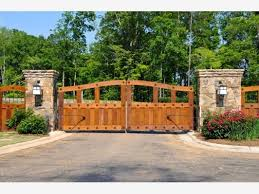

In [18]:
# tale a look at a random image 
import os
# Read in a random image from the training directory
train_img = cv2.imread('/content/drive/My Drive/dsip/allimg/1.jpg')
cv2_imshow(train_img)

### Combine images with labels (preprocess data)

We have to get our images and labels into coco annotation formats already, which has been created using yBat annotation tool. We can try to use them directly. 


### Register Datasets for train and valid

In [19]:
# # Out annotation files are:
# !ls -lt data/train_coco.json data/val_coco.json

In [20]:
import json

In [21]:
train_anno = json.load(open('/content/drive/My Drive/dsip/cocoall.json'))
#valid_anno = json.load(open('data/val_coco.json'))

In [22]:
# In COCO format, annotations are as follows: 
train_anno.keys()#, #valid_anno.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [23]:

train_anno['annotations'][:5]

[{'area': 17028,
  'bbox': [65, 51, 132, 129],
  'category_id': 3,
  'id': 1,
  'ignore': 0,
  'image_id': 1,
  'iscrowd': 0},
 {'area': 1325,
  'bbox': [90, 31, 25, 53],
  'category_id': 1,
  'id': 2,
  'ignore': 0,
  'image_id': 2,
  'iscrowd': 0},
 {'area': 646,
  'bbox': [189, 40, 17, 38],
  'category_id': 1,
  'id': 3,
  'ignore': 0,
  'image_id': 2,
  'iscrowd': 0},
 {'area': 966,
  'bbox': [87, 84, 42, 23],
  'category_id': 2,
  'id': 4,
  'ignore': 0,
  'image_id': 2,
  'iscrowd': 0},
 {'area': 528,
  'bbox': [205, 65, 24, 22],
  'category_id': 2,
  'id': 5,
  'ignore': 0,
  'image_id': 2,
  'iscrowd': 0}]

In [24]:
# Register datasets with Detectron2
# My  dataset is in COCO format, this cell can be replaced by the following lines:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

register_coco_instances("door_train", {}, "/content/drive/My Drive/dsip/cocoall.json", "/content/drive/My Drive/dsip/allimg")
#register_coco_instances("door_valid", {}, "/content/drive/My Drive/door_stairs/cocoval.json", "/content/drive/My Drive/door_stairs/resize")

In [25]:
#DatasetCatalog._REGISTERED

In [26]:
# Check if data sets are registered
{ ds_name: DatasetCatalog._REGISTERED[ds_name] for ds_name in DatasetCatalog._REGISTERED if ds_name in ['door_train']}

{'door_train': <function detectron2.data.datasets.register_coco.register_coco_instances.<locals>.<lambda>>}

In [27]:
# Setup metadata variable
door_metadata = MetadataCatalog.get("door_train")
door_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/My Drive/dsip/allimg', json_file='/content/drive/My Drive/dsip/cocoall.json', name='door_train')

In [28]:
## If needed to register the dataset after deregistering them, then deregister them as below:
## Example of how to remove registered datasets (uncomment only if you need to)
# DatasetCatalog._REGISTERED.pop('firehydrant_train') # remove our training dataset
# DatasetCatalog._REGISTERED.pop('firehydrant_valid') # remove our validation dataset

In [29]:
# # Visualize one annotations to make sure annotations are good. 

# def show_annotations(img, anno):
#   ''' Shows the bounding box at img passed using anno Bbox values as x1,y1,w,h''' 
#   imga = np.copy(img)
#   cv2.rectangle(imga, tuple(anno['bbox'][:2]), (anno['bbox'][0]+ anno['bbox'][2],anno['bbox'][1]+ anno['bbox'][3] ), color=(0, 255, 0), thickness=1)
#   cv2_imshow(imga)

# show_annotations(train_img,train_anno['annotations'][47] )

In [30]:
#cfg.OUTPUT_DIR

### Train with registered datasets

In [31]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("door_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 20000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 20   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/26 18:02:30 d2.engine.hooks]: Overall training speed: 53 iterations in 0:01:29 (1.6829 s / it)
[06/26 18:02:30 d2.engine.hooks]: Total training time: 0:01:29 (0:00:00 on hooks)


KeyboardInterrupt: ignored

In [ ]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

'./output'

In [ ]:
# Save model's configuration
with open("door_model_config.yaml", "w") as f:
    f.write(cfg.dump())

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the firehydrant validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Some basic setup:
# Setup detectron2 logger
import pdb
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() # this logs Detectron2 information such as what the model is doing when it's training

# import some common libraries
import numpy as np
# import pandas as pd
# from tqdm import tqdm
import cv2
import random
import time
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo # a series of pre-trained Detectron2 models: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
from detectron2.engine import DefaultPredictor # a default predictor class to make predictions on an image using a trained model
from detectron2.config import get_cfg # a config of "cfg" in Detectron2 is a series of instructions for building a model
from detectron2.utils.visualizer import Visualizer # a class to help visualize Detectron2 predictions on an image
from detectron2.data import MetadataCatalog # stores information about the model such as what the training/test data is, what the class names are
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg


# Make a prediction and display inferences
def make_inference_firehydrant(image,predictor, model_config, model_weights, threshold=0.7, n=5):
  """
  Makes inference on image (single image) using model_config, model_weights and threshold.

  Returns image with n instance predictions drawn on.

  Params:
  -------
  image (str) : file path to target image
  model_config (str) : file path to model config in .yaml format
  model_weights (str) : file path to model weights 
  threshold (float) : confidence threshold for model prediction, default 0.5
  n (int) : number of prediction instances to draw on, default 5
    Note: some images may not have 5 instances to draw on depending on threshold,
    n=5 means the top 5 instances above the threshold will be drawn on.
  save (bool) : if True will save image with predicted instances to file, default False
  """

  # # Setup config
  # cfg = get_cfg()
  # cfg.merge_from_file(model_config)
  # cfg.MODEL.WEIGHTS = model_weights
  # cfg.MODEL.SCORE_THRESH_TEST = threshold
  # cfg.MODEL.DEVICE='cpu'

  # # Setup predictor
  # predictor = DefaultPredictor(cfg)
  img = cv2.imread(image)
  visualizer = Visualizer(img_rgb=img[:, :, ::-1],
                          metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                          scale=0.4)
  # {'instances': Instances(num_instances=10, image_height=1024, image_width=1280, fields=[pred_boxes: Boxes(tensor([[ 655.8256,  551.0158,  764.3186,  636.2479],
  #       [ 703.4050,  493.9974,  759.8542,  570.9431],
  #       [ 533.7582,  489.0087,  580.3229,  526.6121],
  #       [ 533.5870,  489.5452,  579.6581,  526.3129],
  #       [1048.9978,  523.9127, 1144.0320,  646.8939],
  #       [ 629.2375,  497.2519,  673.5927,  563.9297],
  #       [ 681.6778,  509.0407,  757.9372,  596.8034],
  #       [ 684.1253,  469.9474, 1093.3992,  619.8957],
  #       [ 681.6778,  509.0407,  757.9372,  596.8034],
  #       [ 480.0143,  507.2816,  677.3083,  613.8923]])), scores: tensor([0.9997, 0.9994, 0.9695, 0.2024, 0.1089, 0.1047, 0.0696, 0.0636, 0.0583,
  #       0.0535]), pred_classes: tensor([1, 0, 1, 0, 1, 0, 1, 2, 0, 1])])}
  inference_strat_time = time.time()
  outputs = predictor(img) # Outputs: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.Instances
  print('inference_time : '+str(time.time()-inference_strat_time))
  #print(outputs)
  
  bbox = []
  
  if outputs["instances"].scores.to('cpu').numpy()[0] > threshold:
    
    bbox = outputs["instances"][:n].pred_boxes.to('cpu').tensor.numpy()[0].tolist()
  
  bbox = [int(v) for v in bbox]

  # bboxes : outputs["instances"][:1].pred_boxes.to('cpu').tensor.numpy().tolist()
  # score : outputs["instances"][:1].scores.to('cpu').numpy()[0]

  # Draw on predictions to image
  visualizer = visualizer.draw_instance_predictions(outputs["instances"][:n].to("cpu"))
  fn_base = image.split('.')[0]
  cv2.imwrite(f'{fn_base}_output.jpeg', visualizer.get_image()[:, :, ::-1])
  cv2_imshow(visualizer.get_image()[:, :, ::-1])

  return bbox

  #cv2_imshow(visualizer.get_image())

inference_time : 10.04051685333252


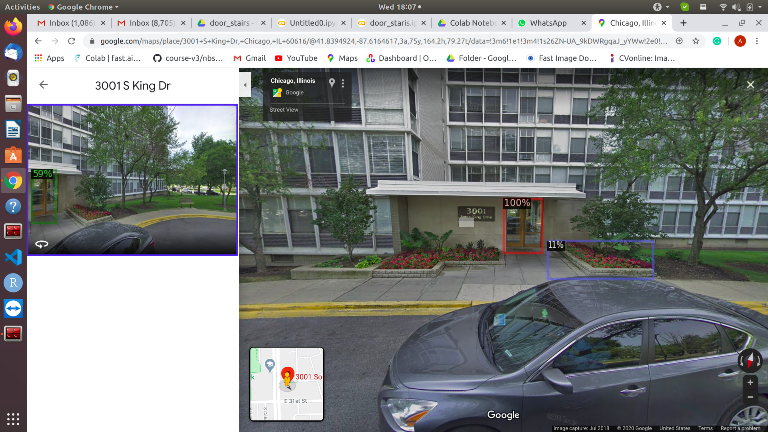

[1260, 497, 1355, 631]

In [ ]:

# Setup config
cfg = get_cfg()
cfg.merge_from_file("/content/drive/My Drive/door_stairs/door_model_config.yaml")
cfg.MODEL.WEIGHTS ="/content/drive/My Drive/door_stairs/model_final.pth"
cfg.MODEL.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE='cpu'
cfg.DATASETS.TEST = ("door_train",)
# Setup predictor
predictor = DefaultPredictor(cfg)

# Make a prediction with the custom model
make_inference_firehydrant('/content/drive/My Drive/door_stairs/s2.png',predictor,
               model_config="door_stairs/door_model_config.yaml",
               model_weights=os.path.join("/content/drive/My Drive/door_stairs/model_final.pth"),
               n=4)